# Task 2 : Building the baseline model

In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dropout, Input, Flatten, Dense, MaxPooling2D
import matplotlib.pyplot as plt
from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline

In [60]:
# constants
img_height = img_width = 128
batch_size = 32
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs = 30

### 1. Set up the classification

In [61]:

# Set random seeds for reproducibility
np.random.seed(123)  
tf.random.set_seed(123) 

# evaluation metrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),  # Accuracy metric
    tf.keras.metrics.AUC(name='auc')  # Area Under Curve metric
]

### 2. Build initial model


In [62]:
# Step 2: Build Initial Model
from tensorflow.keras import datasets, layers, models

model = models.Sequential()

# Convolutional Part
model.add(layers.Input(shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))  # First conv layer
model.add(layers.MaxPooling2D(2, 2))                          # Pooling
model.add(layers.BatchNormalization())                        # Normalization
model.add(layers.Conv2D(64, (3, 3), activation='relu'))      # Second conv layer
model.add(layers.MaxPooling2D(2, 2))                          # Pooling

# Fully Connected Part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))          # Dense layer
model.add(layers.Dropout(0.5))                                # Dropout layer

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))             # Binary classification

# Compile model
#model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,049 (14.14 MB)

 Trainable params: 3,705,985 (14.14 MB)

 Non-trainable params: 64 (256.00 B)

### 3. Train your model

In [63]:
# Use existing data pipelines
train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir=val_dir, train_dir=train_dir)

# Get sample counts (if not already defined)
total_train = train_data_gen.samples
total_val = val_data_gen.samples

# Compile the model (keep your existing METRICS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

# Train the model
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    verbose=1
)




Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/30


c:\Users\Marcin\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step - accuracy: 0.6193 - auc: 0.6566 - loss: 1.7341 - val_accuracy: 0.6450 - val_auc: 0.6919 - val_loss: 0.6751
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 323ms/step - accuracy: 0.7417 - auc: 0.8173 - loss: 0.5288 - val_accuracy: 0.7450 - val_auc: 0.8363 - val_loss: 0.6272
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - accuracy: 0.7392 - auc: 0.8357 - loss: 0.4888 - val_accuracy: 0.7150 - val_auc: 0.8644 - val_loss: 0.5794
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step - accuracy: 0.7823 - auc: 0.8575 - loss: 0.4724 - val_accuracy: 0.7850 - val_auc: 0.8664 - val_loss: 0.5644
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step - accuracy: 0.7913 - auc: 0.8832 - loss: 0.4274 - val_accuracy: 0.7725 - val_auc: 0.8828 - val_loss: 0.5489
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 327ms/step - accuracy: 0.7583 - auc: 0.8428 - loss: 0.4740 - val_accuracy: 0.7575 - val_auc: 0.8555 - val_loss: 0.5303
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 337

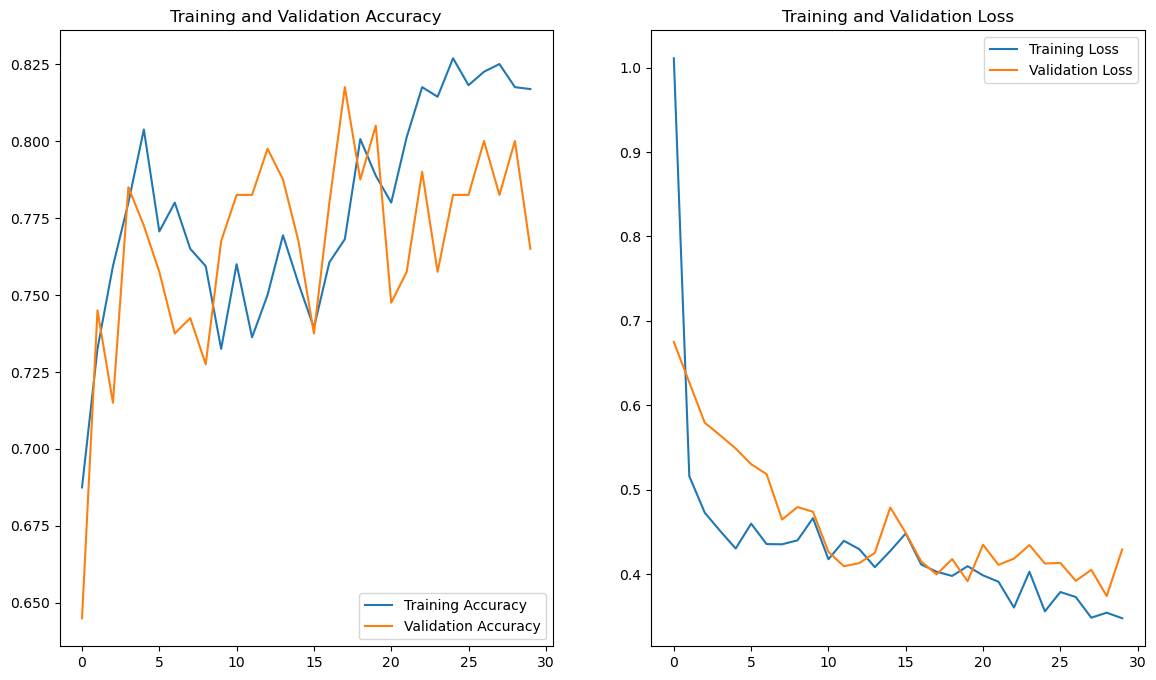

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4. Hyperparameter tuning

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [21]:
!pip install keras-tuner --upgrade


     -------------------------------------- 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [66]:
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt

def build_model(hp):

    # Tune number of filters
    filters = hp.Choice('filters', [32, 64])

    # Tune dropout rate
    dropout_rate = hp.Choice('dropout_rate', [0.3, 0.5])

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    # Tune optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])

    new_model = models.Sequential()

    # Convolutional Part
    new_model.add(layers.Input(shape=(128, 128, 3)))
    new_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))
    new_model.add(layers.MaxPooling2D(2, 2))
    new_model.add(layers.BatchNormalization())
    new_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))
    new_model.add(layers.MaxPooling2D(2, 2))

    # Fully Connected Part
    new_model.add(layers.Flatten())
    new_model.add(layers.Dense(64, activation='relu'))
    new_model.add(layers.Dropout(dropout_rate))

    # Output layer
    new_model.add(layers.Dense(1, activation='sigmoid'))

    # Compile with chosen optimizer and learning rate
    if optimizer_choice == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = optimizers.SGD(learning_rate=learning_rate)

    new_model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return new_model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1
   # directory='kt_dir',
   # project_name='cnn_tuning'
)

tuner.search(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_val // batch_size,
    callbacks=[early_stop]
)


Trial 10 Complete [00h 00m 49s]
val_accuracy: 0.7473958134651184

Best val_accuracy So Far: 0.8125
Total elapsed time: 00h 10m 37s


In [67]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best filter count:", best_hp.get('filters'))
print("Best dropout rate:", best_hp.get('dropout_rate'))
print("Best learning rate:", best_hp.get('learning_rate'))
print("Best optimizer:", best_hp.get('optimizer'))

best_val_acc = tuner.get_best_models(1)[0].evaluate(val_data_gen, verbose=0)[1]

results.append({
        'batch_size': batch_size,
        'learning_rate': best_hp.get('learning_rate'),
        'dropout_rate': best_hp.get('dropout_rate'),
        'val_accuracy': best_val_acc
    })

df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_task2.csv", index=False)

Best filter count: 32
Best dropout rate: 0.3
Best learning rate: 0.0001
Best optimizer: adam


c:\Users\Marcin\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 5. final baseline

In [69]:
full_data_gen = training_data_Pipeline(128, img_size, 'covid xray/train_val')

learning_rate = 0.0001
dropout_rate = 0.3
filters = 32
optimizer = 'adam'

final_model = models.Sequential()

# Convolutional Part
final_model.add(layers.Input(shape=(128, 128, 3)))
final_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))  # First conv layer
final_model.add(layers.MaxPooling2D(2, 2))                          # Pooling
final_model.add(layers.BatchNormalization())                        # Normalization
final_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))      # Second conv layer
final_model.add(layers.MaxPooling2D(2, 2))                          # Pooling

# Fully Connected Part
final_model.add(layers.Flatten())
final_model.add(layers.Dense(64, activation='relu'))          # Dense layer
final_model.add(layers.Dropout(dropout_rate))                                # Dropout layer

# Output layer
final_model.add(layers.Dense(1, activation='sigmoid'))             # Binary classification

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
final_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)

history = model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.8003 - auc: 0.8884 - loss: 0.3987
Epoch 2/30


c:\Users\Marcin\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - accuracy: 0.8029 - auc: 0.9093 - loss: 0.3662
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - accuracy: 0.8125 - auc: 0.9149 - loss: 0.3607
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.8237 - auc: 0.9243 - loss: 0.3313
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.8115 - auc: 0.9077 - loss: 0.3844
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.8310 - auc: 0.9240 - loss: 0.3453
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - accuracy: 0.8194 - auc: 0.9243 - loss: 0.3419
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step - accuracy: 0.8274 - auc: 0.9214 - loss: 0.3369
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - accuracy: 0.8283 - auc: 0.9255 - loss: 0.3347
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.8291 - auc: 0.9215 - loss: 0.3433
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 273ms/step - accuracy: 0.8325 - auc: 0.9286 - loss: 0.3294

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


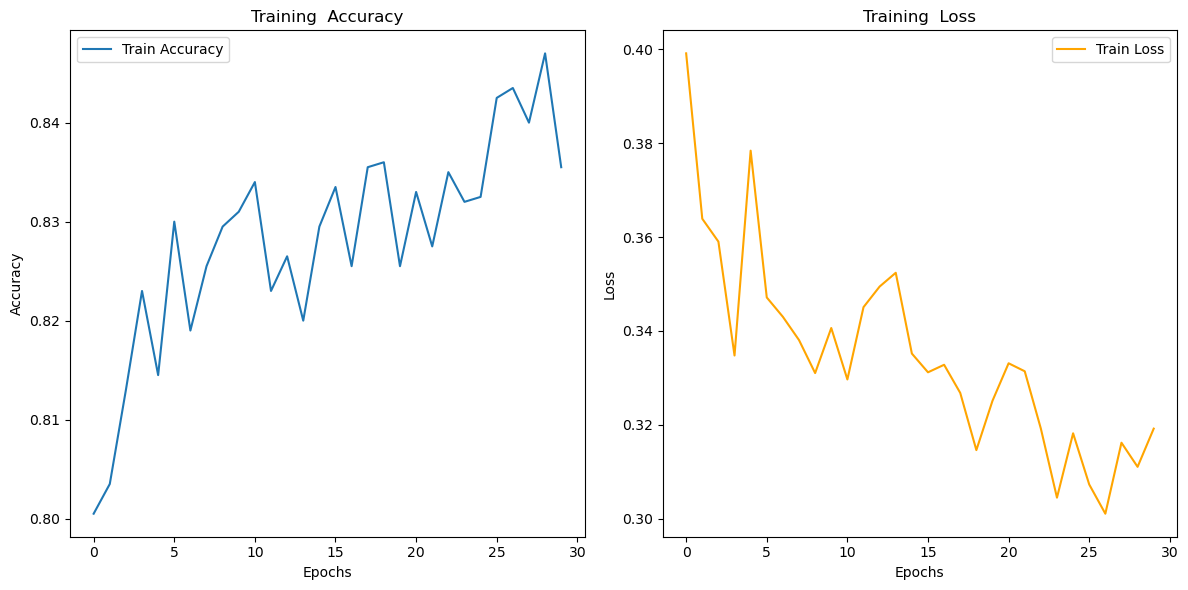

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6644 - auc: 0.6700 - loss: 0.6792
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Test Loss: 0.6818
Test Accuracy: 0.6399


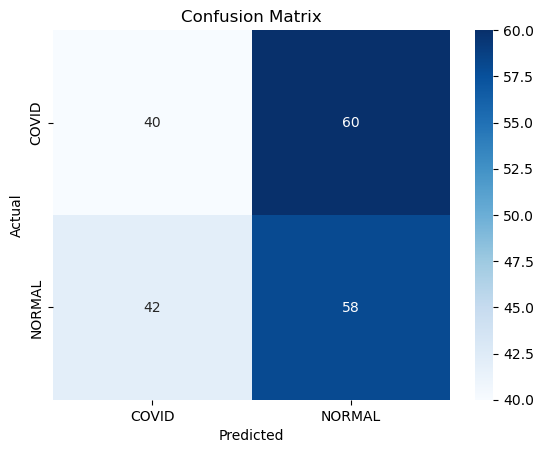

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_data_gen = test_validation_data_Pipeline(batch_size, img_size, 'covid xray/train_val', test_dir)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.title('Training  Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Save the model to disk and load it back
final_model.save('covid_xray_model.h5')  # Save the model
loaded_model = tf.keras.models.load_model('covid_xray_model.h5')  # Load the model

test_data_gen = test_validation_data_Pipeline(batch_size, img_size, 'covid xray/train_val', test_dir)
loss, auc, accuracy = loaded_model.evaluate(test_data_gen)

y_true = test_data_gen.classes
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data_gen.class_indices.keys(), yticklabels=test_data_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# plot a few samples from test set (without vs with normalization)